# Installation and Import library

In [1]:
! pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811597 sha256=4b0b34282fb1602d1ea1bf273b89db935cc6ea6c415cf02e352a9e5d6feff4ae
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [3]:
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# Data preparation

In [4]:
# import data set
data = Dataset.load_builtin('ml-100k')

# split data set
trainset, testset = train_test_split(data, test_size=.3)

# keep the accuracy of each model in dictionary
algo_list = ["SVD", "SlopeOne", "NMF", "KNNBasic", "KNNWithMeans", "KNNWithZScore", "BaselineOnly", "CoClustering"]
rmse_list = []

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


# Training with multiple different model

In [5]:
algorithms = [SVD(), SlopeOne(), NMF(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # perform cross validation
    result = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

    # keep result
    rmse_list.append(round(float(min(result["test_rmse"])), 3))
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ef1d0219420>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7ef1d021a800>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7ef1d021bdc0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7ef1d0219ff0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7ef1d0219f00>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7ef1d021a020>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7ef1d0219f90>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7ef1d0219fc0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ef1d0219420>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ef1d0219420> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7ef1d021a800>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne obj

# Result visualization

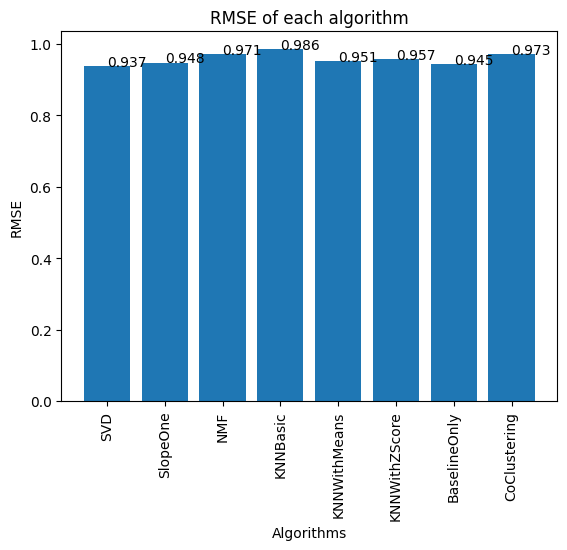

In [6]:
import matplotlib.pyplot as plt

# making the bar chart on the data
plt.bar(algo_list, rmse_list)

# calling the function to add value labels
for i in range(len(algo_list)):
    plt.text(i,rmse_list[i],rmse_list[i])

# giving title to the plot
plt.title("RMSE of each algorithm")

# giving X and Y labels
plt.xlabel("Algorithms")
plt.ylabel("RMSE")
plt.xticks(rotation=90)

# visualizing the plot
plt.show()

# SVD training with tuning

Since the rmse of SVD model is the lowest, I use that model to do further.

In [7]:
#SVD
from surprise import SVD
  #n_epochs: random gradient descent iterations, default = 20.
  #lr_all: learing rate of all attributes, default = 0.005.
  #reg_all: regularization of all attributes, default = 0.02.
param_grid = {"n_epochs": [20, 30, 40], "lr_all": [0.001, 0.002, 0.005], "reg_all": [0.02, 0.08, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, n_jobs=2)
gs.fit(data)

# output best RMSE
print(gs.best_score["rmse"])

# output best attribute combination
print(gs.best_params["rmse"])

best_params = gs.best_params["rmse"]

0.925487213802661
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.08}


# Save and Load trained model

In [8]:
## SAVING TRAINED MODEL
from surprise import dump
import os

# build model
algo = SVD(n_epochs = best_params['n_epochs'], lr_all = best_params['lr_all'], reg_all = best_params['reg_all'])
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
print("accuracy =", accuracy)

model_filename = "./model.pickle"
print (">> Starting dump")

# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)

print (">> Dump done")
print(model_filename)

RMSE: 0.9218
accuracy = <module 'surprise.accuracy' from '/usr/local/lib/python3.10/dist-packages/surprise/accuracy.py'>
>> Starting dump
>> Dump done
./model.pickle


In [9]:
## LOAD SAVED MODEL
model_filename = "./model.pickle"

def load_model(model_filename):
    print (">> Loading dump")
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model

def itemRating(user, item):
    from pprint import pprint as pp
    uid = str(user)
    iid = str(item)
    loaded_model = load_model(model_filename)
    prediction = loaded_model.predict(user, item, verbose=True)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user,
        'item': item,
        'rating': rating,
        'details': details,
        'uid': uid,
        'iid': iid,
        'true': true
        }
    pp (ret)
    print ('\n\n')
    return ret

user = "92"
item  = "12"
print(itemRating(user, item))

>> Loading dump
>> Loaded dump
user: 92         item: 12         r_ui = None   est = 4.45   {'was_impossible': False}
{'details': {'was_impossible': False},
 'iid': '12',
 'item': '12',
 'rating': 4.446329028959714,
 'true': None,
 'uid': '92',
 'user': '92'}



{'user': '92', 'item': '12', 'rating': 4.446329028959714, 'details': {'was_impossible': False}, 'uid': '92', 'iid': '12', 'true': None}


# Get top k recommendation for certain user


The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [10]:
import pandas as pd

def get_Iu(uid):
    """
    args:
      uid: the id of the user
    returns:
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0

def get_Ui(iid):
    """
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0


df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,889,469,4.0,3.441310,{'was_impossible': False},213,44,0.558690
1,389,136,4.0,4.232778,{'was_impossible': False},192,78,0.232778
2,897,866,5.0,3.627730,{'was_impossible': False},121,81,1.372270
3,299,228,3.0,3.651600,{'was_impossible': False},185,162,0.651600
4,445,591,2.0,2.241954,{'was_impossible': False},91,125,0.241954


In [11]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [12]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
28850,181,832,1.0,1.0,{'was_impossible': False},322,15,0.0
26226,747,408,5.0,5.0,{'was_impossible': False},209,79,0.0
22839,181,681,1.0,1.0,{'was_impossible': False},322,21,0.0
22062,118,223,5.0,5.0,{'was_impossible': False},49,81,0.0
9394,907,15,5.0,5.0,{'was_impossible': False},111,211,0.0
24843,507,181,5.0,5.0,{'was_impossible': False},41,334,0.0
13645,330,64,5.0,5.0,{'was_impossible': False},101,185,0.0
21385,507,315,5.0,5.0,{'was_impossible': False},41,112,0.0
7922,181,457,1.0,1.0,{'was_impossible': False},322,17,0.0
7187,118,641,5.0,5.0,{'was_impossible': False},49,18,0.0


In [13]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
25269,1,8,1.0,4.420118,{'was_impossible': False},179,154,3.420118
15654,675,223,1.0,4.534990,{'was_impossible': False},20,81,3.534990
23888,887,718,1.0,4.537724,{'was_impossible': False},116,10,3.537724
2417,137,51,1.0,4.558925,{'was_impossible': False},32,61,3.558925
21447,239,190,1.0,4.574041,{'was_impossible': False},107,91,3.574041
28865,850,98,1.0,4.607107,{'was_impossible': False},36,279,3.607107
8182,887,1012,1.0,4.663391,{'was_impossible': False},116,69,3.663391
6883,405,376,5.0,1.268549,{'was_impossible': False},516,20,3.731451
21027,50,124,1.0,4.834856,{'was_impossible': False},14,126,3.834856
21209,405,571,5.0,1.012596,{'was_impossible': False},516,16,3.987404


In [14]:
from collections import defaultdict
def get_all_predictions(predictions):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

all_pred = get_all_predictions(predictions)

In [15]:
#To get top k recommendations
def get_top_k_recommendations(k, pred):
    for uid, user_ratings in pred.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        pred[uid] = user_ratings[:k]
        #print(uid, pred[uid])

get_top_k_recommendations(3, all_pred)

In [16]:
def getRecommend(uid, pred):
    return pred[str(uid)]

print(getRecommend(498, all_pred))

[('474', 4.083226393695473), ('603', 3.931268573808082), ('187', 3.916917302990145)]
